In [ ]:
# 107303538_1202_1

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim # 最佳化資料庫
from torchvision import datasets
from matplotlib import pyplot as plt

cifar10為numpy

In [ ]:
import os
data_path = os.getcwd() # 在datasets內建有CIFAR10
cifar10 = datasets.CIFAR10(data_path, train=True, download=True) # 第一次下載download為True 
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True) # val不用train

Files already downloaded and verified
Files already downloaded and verified


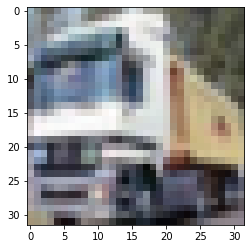

In [ ]:
img, label = cifar10[1] # 取圖片 會回傳一個label和img 
plt.imshow(img)
#plt.show()
# dataset就是index進去會跑圖片和label
# img的類型是PIL.Image

轉成tensor

In [ ]:
from torchvision import transforms
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

In [ ]:
img_t, _ = tensor_cifar10[1] # 抓第1個圖片
#type(img_t)
img_t.shape, img_t.dtype # (3個channel RGB, 圖片大小32*32)

# type() 返回數據結構類型（list、dict、numpy.ndarray 等）
# dtype() 返回數據元素的數據類型（int、float等）
# tensor為float32

(torch.Size([3, 32, 32]), torch.float32)

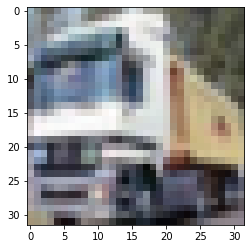

In [ ]:
# tensor顯示圖片
plt.imshow(img_t.permute(1, 2, 0)) # 從tensor(C,H,W)轉到numpy(H,W,C)
plt.show()

標準化

In [ ]:
# 變四軸
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3) # 把tensor_cifar10中所有的5000張圖片放在第四維
# img_t.shape為共5000張torch.Size([3, 32, 32])的圖片疊加
imgs.shape

torch.Size([3, 32, 32, 50000])

In [ ]:
# 2D : 橫軸(列) = 0 / 縱軸(行) = 1 
# 3D : 深度(C) = 0 / 橫軸(列) = 1 / 縱軸(行) = 2
# 4D : 深度(C) = 0 / 橫軸(列) = 1 / 縱軸(行) = 2 / 塊(B) = 3 

# NN  為 ( B, C*H*W )
# train_loader 和 CNN 為 ( B, C, H, W )

In [ ]:
# 標準化
# ?? 三維
imgs.view(3, -1).mean(dim=1) # 3列 其他自動合併(32*32*5000) 變(3,51200000) 為橫向相加求平均 
# tensor([0.4915, 0.4823, 0.4468])
imgs.view(3, -1).std(dim=1) 
# tensor([0.2470, 0.2435, 0.2616])

tensor([0.2470, 0.2435, 0.2616])

cifar10轉tensor和標準化

In [ ]:
transformed_cifar10 = datasets.CIFAR10(
  data_path, train=True, download=True,
  transform=transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.4915, 0.4823, 0.4468),
  (0.2470, 0.2435, 0.2616))
]))
# val組
transformed_cifar10_val = datasets.CIFAR10(
  data_path, train=False, download=True,
  transform=transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.4915, 0.4823, 0.4468),
  (0.2470, 0.2435, 0.2616))
]))

Files already downloaded and verified
Files already downloaded and verified


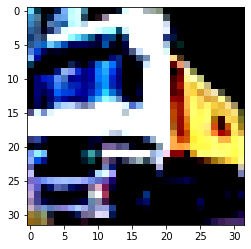

In [ ]:
# tensor顯示圖片
img_t, _ = transformed_cifar10[1] # 必回傳一圖片+label
plt.imshow(img_t.permute(1, 2, 0)) # 從tensor(C,H,W)轉到numpy(H,W,C)
plt.show()

分辨飛機與鳥cifar2

In [ ]:
# 只取鳥和飛機
label_map = {0: 0, 2: 1} #  {key1 : value1, key2 : value2 } {飛機: 新的array的0位置, 鳥: 新的array的1位置} ex.為0就轉換為0 為2就轉換為1
class_names = ['airplane', 'bird'] 

# 若label為0和2 匯出其img和label label放到label_map轉換整數值
cifar2 = [(img, label_map[label]) 
      for img, label in transformed_cifar10
      if label in [0, 2]]
cifar2_val = [(img, label_map[label])
        for img, label in transformed_cifar10_val
        if label in [0, 2]]

softmax

In [ ]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
          [1.0, 2.0, 3.0]])
# 為橫向比較(結果橫向會為1.)
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

訓練模型(softmax)

In [ ]:
model = nn.Sequential(
      nn.Linear(3072, 512), # 標準化後為(3,1024) 共有3*1024=3072個計算點 512為自設
      nn.Tanh(),
      nn.Linear(512, 2), # 匯入資料庫為cifar2 所以最後僅會輸出鳥或飛機的機率
      nn.Softmax(dim=1)) 
# nn訓練模型標準化輸入為(batch, 圖片)

訓練一張圖片

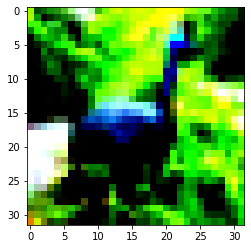

In [ ]:
img, _ = cifar2[0] # img為tensor
# img.shape為torch.Size([3, 32, 32])
plt.imshow(img.permute(1, 2, 0)) # 從tensor(C,H,W)轉到numpy(H,W,C)

In [ ]:
# 調整tensor為了fit model
img_batch = img.view(-1).unsqueeze(0) # 合併[3, 32, 32]變成一維3072(也就是一張圖片RGB+大小) 增加列變torch.Size([1, 3072])
out = model(img_batch) # 訓練結果 拿到對於飛機和鳥的機率
out 

tensor([[0.6106, 0.3894]], grad_fn=<SoftmaxBackward0>)

In [ ]:
_, index = torch.max(out, dim=1) # 分類 兩個機率中較大的 即為越像該物
class_names[index]
# torch.max 返回 (最大值, 索引)

'airplane'

訓練模型(LogSoftmax)

In [ ]:
# 訓練層
model = nn.Sequential(
      nn.Linear(3072, 512),
      nn.Tanh(),
      nn.Linear(512, 2),
      nn.LogSoftmax(dim=1))

In [ ]:
loss_fn = nn.NLLLoss() # 其相對應的loss function

In [ ]:
learning_rate = 1e-2 # 學習率
optimizer = optim.SGD(model.parameters(), lr=learning_rate) # 優化器

In [ ]:
n_epochs = 1
for epoch in range(n_epochs):
  for img, label in cifar2: # 已經只有鳥和飛機的資料庫cifar2
    out = model(img.view(-1).unsqueeze(0)) # 皆變成一維 輸出飛機和鳥的機率
    loss = loss_fn(out, torch.tensor([label])) # out為訓練出來model猜的機率 torch.tensor([label])為label_map[label]為真正的機率0或1 訓練再回饋

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 4.176211


In [ ]:
# tensor 轉 numpy , b = a.numpy()
# numpy(array) 轉 tensor, b = torch.from_numpy(a)
# numpy(array) 轉 tensor, b = torch.tensor(a)